# TP7 Deep Learning 

Cette septième séance porte sur l'explicabilité et a pour but:
* d'utiliser un package python implémentant différentes stratégies d'explicabilité.
* de vous faire programmer la recherche des crops d'images dans un dataset qui activent le plus des filtres d'une couche de convolution donnée. 
* de vous faire programmer la descente de gradient dans l'espace d'entrée pour déterminer l'image qui active le plus un neurone.





## Imports et lien au Google Drive

In [1]:
try:
    %tensorflow_version 2.x
    import tensorflow as tf
    from tensorflow.keras import layers
    from tensorflow.keras.datasets import mnist
    from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
    from tensorflow.keras.preprocessing import image

    import cv2
    import json
    import time
    import numpy as np
    import matplotlib.pyplot as plt

    from google.colab.patches import cv2_imshow
except Exception:
    print('Tensorflow version 2 not available')

TensorFlow 2.x selected.


## Package keras-explain

Nous allons utiiser ce package dont la documentation succinte... se trouve ici: https://pypi.org/project/keras-explain/


In [0]:
# !pip install keras-explain

# Back to Convolution Maps visualization (from TP2)


<h4>Visualisation des cartes</h4>

Une carte "réponse" (ou feature map) d'une couche de convolution correspond à l'état des activations en sortie d'une telle couche. Leur contenu dépend donc d'une image passée en entrée du réseau. 

Une couche définie pour apprendre 64 filtres de convolution, génère ainsi 64 cartes. On définie d'abord une fonction pour l'affichage d'un tableau d'images (via matplotlib)

In [0]:
def show_images(images, cols=1):
    n_images = len(images)
    fig = plt.figure()
    for n, image in enumerate(images):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        plt.axis('off')
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)

<h3> Utilisation d'un CNN pour des images naturelles </h3>

Les filtres de convolutions appris sur les données MNIST ne sont pas très parlantes, intéressons nous plutôt à un réseau (beaucoup plus profond) adapté à la classification d'images naturelles. Nous allons considérer pour cela le réseau VGG16, pré-entrainé sur le dataset ImageNet (cf cours).

In [4]:
!wget https://pageperso.lis-lab.fr/stephane.ayache/cat.jpg
!wget https://pageperso.lis-lab.fr/stephane.ayache/imagenet_class_index.json 

# chargement d'un dictionnaire qui met en correspondant l'index
# d'une classe ImageNet et son nom
with open('imagenet_class_index.json') as f:
    CLASS_INDEX = json.load(f)

# Récupération du modèle complet VGG16
model3 = VGG16(include_top=True, weights='imagenet')
print(model3.summary())

# chargement et preprocess de l'image (dont normalisation et redimensionnement)
img_path = 'cat.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# prédiction et affichage de la classe de probabilité maximale
softmax_output = model3.predict(x)
best_class = np.argmax(softmax_output)
im_class = CLASS_INDEX[str(best_class)][1]
print("prediction: ", im_class)

--2019-11-19 15:56:50--  https://pageperso.lis-lab.fr/stephane.ayache/cat.jpg
Resolving pageperso.lis-lab.fr (pageperso.lis-lab.fr)... 139.124.22.27
Connecting to pageperso.lis-lab.fr (pageperso.lis-lab.fr)|139.124.22.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86130 (84K) [image/jpeg]
Saving to: ‘cat.jpg’

cat.jpg             100%[===================>]  84.11K   159KB/s    in 0.5s    

2019-11-19 15:56:52 (159 KB/s) - ‘cat.jpg’ saved [86130/86130]

--2019-11-19 15:56:54--  https://pageperso.lis-lab.fr/stephane.ayache/imagenet_class_index.json
Resolving pageperso.lis-lab.fr (pageperso.lis-lab.fr)... 139.124.22.27
Connecting to pageperso.lis-lab.fr (pageperso.lis-lab.fr)|139.124.22.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/json]
Saving to: ‘imagenet_class_index.json’

imagenet_class_inde 100%[===================>]  34.53K   129KB/s    in 0.3s    

2019-11-19 15:56:56 (129 KB/s) - ‘imagenet_class

Notre chaton a été reconnu comme un chat ? Alors tout va bien, et regardons les filtres de la première couche ...

-0.67140007 0.6085159


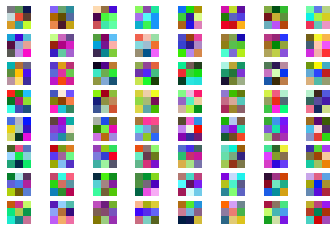

In [5]:
weights = model3.get_weights()
#for w in weights: print(w.shape)
  
# normalize values between 0 and 1
minimum, maximum = np.min(weights[0]), np.max(weights[0])
weights0 = (weights[0] - minimum) / (maximum - minimum)

print(minimum, maximum)
# entre 0 et 255 pour l'affichage
weights0 *= 255.

images = []
for i in range(64):
  images.append(np.array(255*weights0[:,:,:,i]).reshape(3,3,3).astype('uint8'))

show_images(images, 8)

# Utilisation de différentes visualisations

Utilisez le package keras-explain et comparez les différenbtes stratégies qui sont implémentées pour expliquer les décisions notamment sur l'image de chat téléchargée plus haut puis sur quelques autres images.

* GradCAM

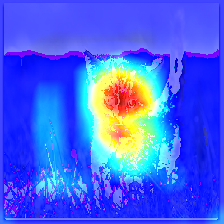

In [6]:
class MyGradCAM:
    def __init__(self, model, layer_name):
        self.model = model
        self.layer_name = layer_name

        # the model will explain the final output `model.output`
        # according to a specific layer `model.get_layer(layer_name).output`
        self.gradCAM = tf.keras.Model(
            [model.inputs], [model.get_layer(layer_name).output, model.output]
        )
    
    def fit(self, img, predicted_class):
        # compute convolutional outputs and loss
        # according to the predicted class
        with tf.GradientTape() as tape:
            conv_outputs, predictions = self.gradCAM(np.array([img]))
            loss = predictions[:, predicted_class]
        
        # get the gradients
        output = conv_outputs[0]
        grads = tape.gradient(loss, conv_outputs)[0]

        # inject gradients
        gate_f = tf.cast(output > 0, 'float32')
        gate_r = tf.cast(grads > 0, 'float32')
        guided_grads = gate_f * gate_r * grads

        weights = tf.reduce_mean(guided_grads, axis=(0, 1))

        # add all the weights together 
        cam = np.ones(output.shape[0:2], dtype = np.float32)
        for i, w in enumerate(weights):
            cam += w * output[:, :, i]
        
        return self.get_heatmap(img, cam)
    
    def get_heatmap(self, img, cam):
        cam = cv2.resize(cam.numpy(), (224, 224))
        cam = np.maximum(cam, 0)
        heatmap = (cam - cam.min()) / (cam.max() - cam.min())

        cam = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
        return cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, cam, 1, 0)


# chargement et preprocess de l'image (dont normalisation et redimensionnement)
img_path = 'cat.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x_for_cam = image.img_to_array(img)
x_for_convnet = preprocess_input(np.expand_dims(x_for_cam, axis=0))

# prédiction et affichage de la classe de probabilité maximale
softmax_output = model3.predict(x_for_convnet)
best_class = np.argmax(softmax_output)

# calcul et affichage de la Class Activation Mapping
grad_model = MyGradCAM(model3, 'block5_conv3')
grad_heatmap = grad_model.fit(x_for_cam, best_class)                                                                 
cv2_imshow(grad_heatmap)

* Guided Backrop

In [0]:
from tensorflow.keras.models import load_model

class SaliencyMask(object):
    """Base class for saliency masks. Alone, this class doesn't do anything."""
    def __init__(self, model, output_index=0):
        """Constructs a SaliencyMask.
        Args:
            model: the keras model used to make prediction
            output_index: the index of the node in the last layer to take derivative on
        """
        pass

    def get_mask(self, input_image):
        """Returns an unsmoothed mask.
        Args:
            input_image: input image with shape (H, W, 3).
        """
        pass

    def get_smoothed_mask(self, input_image, stdev_spread=.2, nsamples=50):
        """Returns a mask that is smoothed with the SmoothGrad method.
        Args:
            input_image: input image with shape (H, W, 3).
        """
        stdev = stdev_spread * (np.max(input_image) - np.min(input_image))

        total_gradients = np.zeros_like(input_image)
        for i in range(nsamples):
            noise = np.random.normal(0, stdev, input_image.shape)
            x_value_plus_noise = input_image + noise

            total_gradients += self.get_mask(x_value_plus_noise)

        return total_gradients / nsamples

class GradientSaliency(SaliencyMask):
    r"""A SaliencyMask class that computes saliency masks with a gradient."""

    def __init__(self, model, output_index=0):
        # Define the function to compute the gradient
        input_tensors = [model.input,        # placeholder for input image tensor
                         tf.learning_phase(), # placeholder for mode (train or test) tense
                        ]
        gradients = model.optimizer.get_gradients(model.output[0][output_index], model.input)
        self.compute_gradients = K.function(inputs=input_tensors, outputs=gradients)

    def get_mask(self, input_image):
        """Returns a vanilla gradient mask.
        Args:
            input_image: input image with shape (H, W, 3).
        """
        
        # Execute the function to compute the gradient
        x_value = np.expand_dims(input_image, axis=0)
        gradients = self.compute_gradients([x_value, 0])[0][0]

        return gradients

class GuidedBackprop(SaliencyMask):
    """A SaliencyMask class that computes saliency masks with GuidedBackProp.
    This implementation copies the TensorFlow graph to a new graph with the ReLU
    gradient overwritten as in the paper:
    https://arxiv.org/abs/1412.6806
    """

    GuidedReluRegistered = False

    def __init__(self, model, output_index=0, custom_loss=None):
        """Constructs a GuidedBackprop SaliencyMask."""

        if GuidedBackprop.GuidedReluRegistered is False:
            @tf.RegisterGradient("GuidedRelu")
            def _GuidedReluGrad(op, grad):
                gate_g = tf.cast(grad > 0, "float32")
                gate_y = tf.cast(op.outputs[0] > 0, "float32")
                return gate_y * gate_g * grad
        GuidedBackprop.GuidedReluRegistered = True
        
        """ 
            Create a dummy session to set the learning phase to 0 (test mode in keras) without 
            inteferring with the session in the original keras model. This is a workaround
            for the problem that tf.gradients returns error with keras models that contains 
            Dropout or BatchNormalization.
            Basic Idea: save keras model => create new keras model with learning phase set to 0 => save
            the tensorflow graph => create new tensorflow graph with ReLU replaced by GuiededReLU.
        """   
        model.save('/tmp/gb_keras.h5') 
        with tf.Graph().as_default(): 
            with tf.Session().as_default(): 
                K.set_learning_phase(0)
                load_model('/tmp/gb_keras.h5', custom_objects={"custom_loss":custom_loss})
                session = K.get_session()
                tf.train.export_meta_graph()
                
                saver = tf.train.Saver()
                saver.save(session, '/tmp/guided_backprop_ckpt')

        self.guided_graph = tf.Graph()
        with self.guided_graph.as_default():
            self.guided_sess = tf.session(graph = self.guided_graph)

            with self.guided_graph.gradient_override_map({'Relu': 'GuidedRelu'}):
                saver = tf.train.import_meta_graph('/tmp/guided_backprop_ckpt.meta')
                saver.restore(self.guided_sess, '/tmp/guided_backprop_ckpt')

                self.imported_y = self.guided_graph.get_tensor_by_name(model.output.name)[0][output_index]
                self.imported_x = self.guided_graph.get_tensor_by_name(model.input.name)

                self.guided_grads_node = tf.gradients(self.imported_y, self.imported_x)
        
    def get_mask(self, input_image):
        """Returns a GuidedBackprop mask."""
        x_value = np.expand_dims(input_image, axis=0)
        guided_feed_dict = {}
        guided_feed_dict[self.imported_x] = x_value        

        gradients = self.guided_sess.run(self.guided_grads_node, feed_dict = guided_feed_dict)[0][0]

        return gradients

class GuidedBP:
    name = "Guided Back Propagation"
    authors = "Springerberg et al."

    def __init__(self, model):
        self.model = model

    def explain(self, image, target_class):
        guided_bprop = GuidedBackprop(self.model,
                                      output_index=target_class)
        mask = guided_bprop.get_mask(image)

        # ignoring negative activations since they come only from the
        # last layer, since guided backprop does not propagate negative values
        # through the ReLU

        mask[mask < 0] = 0
        mask = np.sum(mask, axis=2)
        # mask = np.abs(mask)
        mask /= mask.max()  # values should be between 0 and 1
        print(mask.max())

        return mask, None

In [0]:
# calcul et affichage de la la GuidedBackPropagation
guided_bp_model = GuidedBP(model3)
mask = guided_bp_model.explain(x_for_cam, best_class)                                                                 
cv2_imshow(mask)

AttributeError: ignored

* LRP

In [0]:
class LRP:
    name = "Layer-wise Relevance Propagation"
    authors = "Bach et al."

    def __init__(self, model, alpha=2, beta=1):
        self.model = model
        self.alpha = alpha
        self.beta = beta

        warnings.warn("LRP is still in the testing phase. Be warned that some"
                      "bugs could be present. If you find any"
                      "please do not hesitate to report it on github: "
                      "https://github.com/PrimozGodec/keras-explain/issues")

    def explain(self, image, target_class):
        model = self.model

        # retrieve outputs of all layers
        outputs = self.get_layers_outputs(model, image)

        relevances = {}  # key: layer name, value: relevance of input tensor

        # retrieve the output layer
        output_layer = model.layers[-1]  # TODO: Check if true

        target_activations = outputs[output_layer.name]
        print(target_activations.shape)
        target_activations_modified = np.zeros(target_activations.shape)
        target_activations_modified[:, target_class] = \
            target_activations[:, target_class]

        previous = [output_layer]
        new_r = None

        while len(previous) > 0:
            curr_layer = previous[0]
            print("curr", curr_layer)
            print("curr", curr_layer.name)

            # get layer before

            previous_layer = self._get_layer_before(curr_layer)

            previous = previous[1:] + \
                       [previous_layer] if previous_layer is not None else []

            # layer after
            out_node = curr_layer._outbound_nodes

            next_layer = None
            if len(out_node) > 0:
                next_layer = out_node[0].outbound_layer
            if next_layer is not None:
                print("next", next_layer.name)

            previous = previous[1:] + \
                       [previous_layer] if previous_layer is not None else []

            # print(previous_layer)


            # get previous layer relevance
            r = target_activations_modified if next_layer is None \
                else relevances[next_layer.name]
            if not isinstance(curr_layer, InputLayer):
                x = outputs[previous_layer.name]
                w = curr_layer.get_weights()

            if isinstance(curr_layer, Dense):
                new_r = self.lrp_dense(r, x, w)
            elif isinstance(curr_layer, Dropout):
                new_r = self.lrp_layer_skip(r)
            elif isinstance(curr_layer, Flatten):
                new_r = self.lrp_flatten(r, x)
            elif isinstance(curr_layer, MaxPooling2D):
                new_r = self.lrp_max_pooling(
                    r, x, outputs[curr_layer.name],
                    curr_layer.pool_size, curr_layer.strides)
            elif isinstance(curr_layer, InputLayer):
                new_r = r.copy()
                print("here")
            elif isinstance(curr_layer, Conv2D):
                new_r = self.lrp_conv2D(r, x, w, curr_layer.strides)
            else:
                print("Layer %s is not supported by the LRP implemented in"
                      "this framework. You can implement it and create the "
                      "pull request on the GitHub or write the issue." %
                      curr_layer)
                raise LayerNotImplementedException

            relevances[curr_layer.name] = new_r
            print(new_r.shape)

        print(new_r.shape)
        return np.sum(new_r[0, ...], axis=-1), None

    def _get_layer_before(self, layer):
        previous_layer = None
        in_node = layer._inbound_nodes
        if len(in_node) > 0 and len(in_node[0].inbound_layers) > 0:
            previous_layer = in_node[0].inbound_layers[0]
        return previous_layer


    def get_layers_outputs(self, model, input):
        # retrieve layers
        layers = model.layers

        # get activations
        activations = {}  # each layer will be accessible by name
        for layer in layers:
            out_fun = K.function([model.layers[0].input], [layer.output])
            layer_output = out_fun([input[None, ...]])[0]
            activations[layer.name] = layer_output

            # check if layer has input layer attached
            if hasattr(layer, "batch_input_shape"):
                print(layer.batch_input_shape)
                input_layer = self._get_layer_before(layer)
                out_fun = K.function([model.layers[0].input], [input_layer.output])
                layer_output = out_fun([input[None, ...]])[0]
                activations[input_layer.name] = layer_output

        return activations

    def lrp_dense(self, r, x, w):
        b = w[1]  # bias
        w = w[0]  # weights

        z = w[np.newaxis, :] * x[:, :, np.newaxis]

        zp = z * (z > 0)
        zn = z * (z < 0)

        zsp = np.sum(zp, axis=1) + (b * (b > 0))[np.newaxis, :]
        zsn = np.sum(zn, axis=1) + (b * (b > 0))[np.newaxis, :]

        zp = zp / zsp
        zn = zn / zsn

        r_new = self.alpha * np.sum(zp * r[:, np.newaxis, :], axis=2) + \
            self.beta * np.sum(zn * r[:, np.newaxis, :], axis=2)

        return r_new

    def lrp_layer_skip(self, r):
        return r

    def lrp_flatten(self, r, x):
        return np.reshape(r, x.shape)

    def lrp_max_pooling(self, r, x, y, pool_size, strides):
        n, h, w, d = x.shape

        h_pool, w_pool = pool_size
        h_stride, w_stride = strides

        hout, wout = r.shape[1:3]

        r_x = np.zeros_like(x, dtype=np.float)

        for i in range(hout):
            for j in range(wout):
                z = y[:,i:i+1,j:j+1,:] == x[:, i * h_stride: i * h_stride + h_pool, j * w_stride: j * w_stride + w_pool, :]
                zs = z.sum(axis=(1,2),keepdims=True,dtype=np.float)
                r_x[:, i * h_stride: i * h_stride + h_pool, j * w_stride: j * w_stride + w_pool, :] \
                    += (z / zs) * r[:, i:i+1,j:j+1, :]
        return r_x

    def lrp_conv2D(self, r, x, w, stride):
        b = w[1]  # bias
        w = w[0]  # weights

        na = np.newaxis

        N, Hout, Wout, NF = r.shape
        hf, wf, df, NF = w.shape
        hstride, wstride = stride

        Rx = np.zeros_like(x, dtype=np.float)

        for i in range(Hout):
            for j in range(Wout):
                Z = w[na, ...] * x[:, i * hstride:i * hstride + hf,
                                      j * wstride:j * wstride + wf, :, na]
                # alpha part
                Zp = Z * (Z > 0)
                Bp = (b * (b > 0))[na, na, na, na, ...]
                Zsp = Zp.sum(axis=(1, 2, 3), keepdims=True) + Bp
                Ralpha = self.alpha * (
                    (Zp / Zsp) * r[:, i:i + 1, j:j + 1, na, :]).sum(axis=4)
                Ralpha[np.isnan(Ralpha)] = 0

                Zn = Z * (Z < 0)
                Bn = (b * (b < 0))[na, na, na, na, ...]
                Zsn = Zn.sum(axis=(1, 2, 3), keepdims=True) + Bn
                Rbeta = self.beta * (
                    (Zn / Zsn) * r[:, i:i + 1, j:j + 1, na, :]).sum(axis=4)
                Rbeta[np.isnan(Rbeta)] = 0

                Rx[:, i * hstride:i * hstride + hf:,
                j * wstride:j * wstride + wf:, :] += Ralpha + Rbeta

        return Rx

# Explicabilité par découverte des patchs qui activent le plus certains neurones (ou certains filtres de couches convolutionnelles) d'un DNN
  

## To do

Vous devez implémenter la recherche et l'affichage dans une base de données (tiny imagenet ou une partie de cette base) des images ou crops d'images qui activent le plus : 
- certains neurones des couches denses fc1 et fc2 
- certaines filtres d'une couche convolutionelle du réseau.

Vous pourrez vous inspirer des codes du TP2.

**http://cs231n.github.io/understanding-cnn/**


# Maximisation d'activation

## To do 

Mettez en oeuvre, avec le code fourni en TP2, l'explicabilité d'un neurone d'un DNN par maximisation de l'activation de ce neurone, en suivant le gradient de la sortie par rapport aux entrées, ce qui revient à déterminer une image (artificielle) dont VGG16 obtient une forte réponse à la convolution du filtre ciblé.